# Language Translation
In this project, We are building a language translation model called `seq2seq model or encoder-decoder model` in TensorFlow. The objective of the model is translating English sentences to French sentences. We are going to show the detailed steps, and they will answer to the questions like `how to preprocess the dataset`, `how to define inputs`, `how to define encoder model`, `how to define decoder model`, `how to build the entire seq2seq model`, `how to calculate the loss and clip gradients`, and `how to train and get prediction`.
 

## Get the Data
We are using the reduced size of the original dataset ([WMT10 French-English corpus](http://www.statmt.org/wmt10/training-giga-fren.tar)).

We are using Tensorflow 1.x for this project

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
tf.__version__

'1.15.2'

**Importing libraries and loading the dataset**

In [ ]:
import os
import pickle
import copy
import numpy as np

def load_data(path):
    input_file = os.path.join(path)
    with open(input_file, 'r', encoding='utf-8') as f:
        data = f.read()

    return data

In [ ]:
source_path = 'small_vocab_en'
target_path = 'small_vocab_fr'
source_text = load_data(source_path)
target_text = load_data(target_path)

## Exploratory data analysis

`note: ` The two dataset files exactly contains the same number of lines. Each i-th line in both files has the same meaning but expressed in different languages.

In [ ]:
import numpy as np
from collections import Counter

print('Dataset Brief Stats')
print('* number of unique words in English sample sentences: {}\
        [this is roughly measured/without any preprocessing]'.format(len(Counter(source_text.split()))))
print()

english_sentences = source_text.split('\n')
print('* English sentences')
print('\t- number of sentences: {}'.format(len(english_sentences)))
print('\t- avg. number of words in a sentence: {}'.format(np.average([len(sentence.split()) for sentence in english_sentences])))

french_sentences = target_text.split('\n')
print('* French sentences')
print('\t- number of sentences: {} [data integrity check / should have the same number]'.format(len(french_sentences)))
print('\t- avg. number of words in a sentence: {}'.format(np.average([len(sentence.split()) for sentence in french_sentences])))
print()

sample_sentence_range = (0, 5)
side_by_side_sentences = list(zip(english_sentences, french_sentences))[sample_sentence_range[0]:sample_sentence_range[1]]
print('* Sample sentences range from {} to {}'.format(sample_sentence_range[0], sample_sentence_range[1]))

for index, sentence in enumerate(side_by_side_sentences):
    en_sent, fr_sent = sentence
    print('[{}-th] sentence'.format(index+1))
    print('\tEN: {}'.format(en_sent))
    print('\tFR: {}'.format(fr_sent))
    print()

Dataset Brief Stats
* number of unique words in English sample sentences: 227        [this is roughly measured/without any preprocessing]

* English sentences
	- number of sentences: 137861
	- avg. number of words in a sentence: 13.225277634719028
* French sentences
	- number of sentences: 137861 [data integrity check / should have the same number]
	- avg. number of words in a sentence: 14.226612312401622

* Sample sentences range from 0 to 5
[1-th] sentence
	EN: new jersey is sometimes quiet during autumn , and it is snowy in april .
	FR: new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

[2-th] sentence
	EN: the united states is usually chilly during july , and it is usually freezing in november .
	FR: les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .

[3-th] sentence
	EN: california is usually quiet during march , and it is usually hot in june .
	FR: california est généralement calme en mars , et il est généraleme

## Preprocessing

Here are brief overview what steps will be done in this section

- **create lookup tables** 
  - create two mapping tables 
      - (key, value) == (unique word string, its unique index)     - `(1)`
      - (key, value) == (its unique index, unique word string)     - `(2)`
      - `(1)` is used in the next step, and (2) is used later for prediction step
      
      
- **text to word ids**
  - convert each string word in the list of sentences to the index
  - `(1)` is used for converting process
  
  
- **save the pre-processed data**
  - create two `(1)` mapping tables for English and French
  - using the mapping tables, replace strings in the original source and target dataset with indicies

### Create Lookup Tables

As mentioned breifly, I am going to implement a function to create lookup tables. Since every models are mathmatically represented, the input and the output(prediction) should also be represented as numbers. That is why this step is necessary for NLP problem because human readable text is not machine readable. This function takes a list of sentences and returns two mapping tables (dictionary data type). Along with the list of sentences, there are special tokens, `<PAD>`, `<EOS>`, `<UNK>`, and `<GO>` to be added in the mapping tables. 

- (key, value) == (unique word string, its unique index)     - `(1)`
- (key, value) == (its unique index, unique word string)     - `(2)`

`(1)` will be used in the next step, `test to word ids`, to find a match between word and its index. `(2)` is not used in pre-processing step, but `(2)` will be used later. After making a prediction, the sequences of words in the output sentence will be represented as their indicies. The predicted output is machine readable but not human readable. That is why we need `(2)` to convert each indicies of words back into human readable words in string.




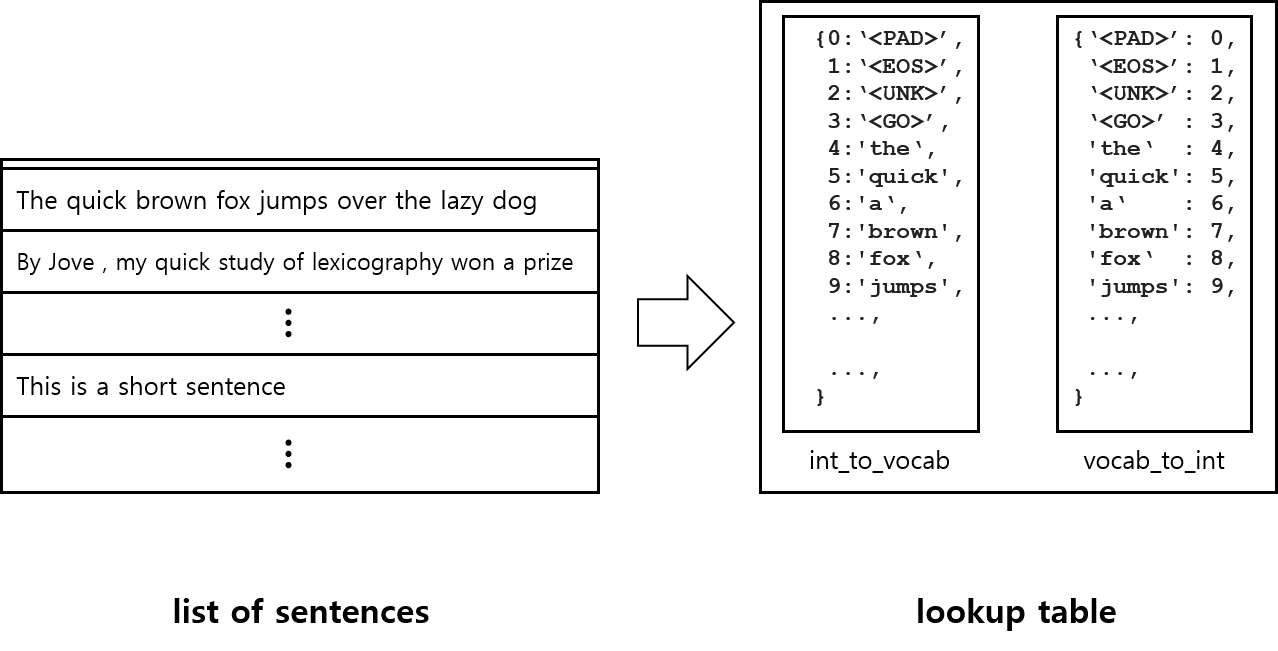

In [ ]:
CODES = {'<PAD>': 0, '<EOS>': 1, '<UNK>': 2, '<GO>': 3 }

def create_lookup_tables(text):
    # make a list of unique words
    vocab = set(text.split())

    # (1)
    # starts with the special tokens
    vocab_to_int = copy.copy(CODES)

    # the index (v_i) will starts from 4 (the 2nd arg in enumerate() specifies the starting index)
    # since vocab_to_int already contains special tokens
    for v_i, v in enumerate(vocab, len(CODES)):
        vocab_to_int[v] = v_i

    # (2)
    int_to_vocab = {v_i: v for v, v_i in vocab_to_int.items()}

    return vocab_to_int, int_to_vocab

### Text to Word Ids

Two `(1)` lookup tables will be provided in `text_to_ids` functions as arguments. They will be used in the converting process for English(source) and French(target) respectively.

- original(raw) source & target datas contain a list of sentences
  - they are represented as a string 

- the number of sentences are the same for English and French
 
- by accessing each sentences, need to convert word into the corresponding index.
  - each word should be stored in a list
  - this makes the resuling list as a 2-D array ( row: sentence, column: word index )
  
- for every target sentences, special token, `<EOS>` should be inserted at the end
  - this token suggests when to stop creating a sequence
  


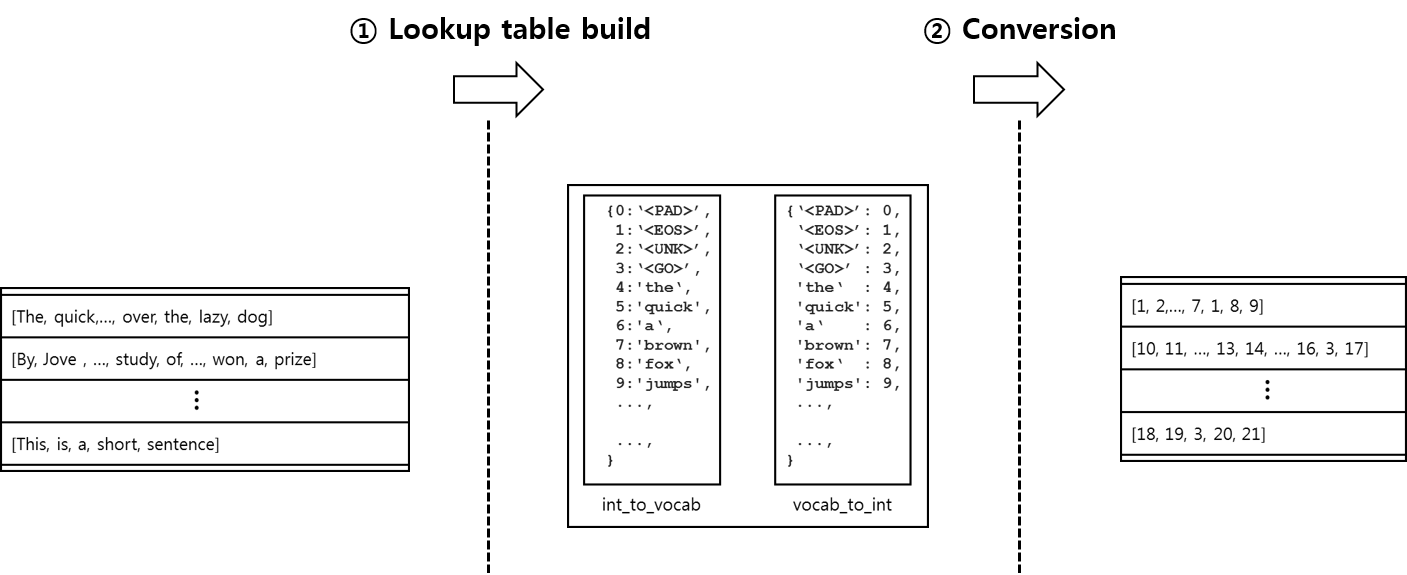

In [ ]:
def text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int):
    """
        1st, 2nd args: raw string text to be converted
        3rd, 4th args: lookup tables for 1st and 2nd args respectively
    
        return: A tuple of lists (source_id_text, target_id_text) converted
    """
    # empty list of converted sentences
    source_text_id = []
    target_text_id = []
    
    # make a list of sentences (extraction)
    source_sentences = source_text.split("\n")
    target_sentences = target_text.split("\n")
    
    max_source_sentence_length = max([len(sentence.split(" ")) for sentence in source_sentences])
    max_target_sentence_length = max([len(sentence.split(" ")) for sentence in target_sentences])
    
    # iterating through each sentences (# of sentences in source&target is the same)
    for i in range(len(source_sentences)):
        # extract sentences one by one
        source_sentence = source_sentences[i]
        target_sentence = target_sentences[i]
        
        # make a list of tokens/words (extraction) from the chosen sentence
        source_tokens = source_sentence.split(" ")
        target_tokens = target_sentence.split(" ")
        
        # empty list of converted words to index in the chosen sentence
        source_token_id = []
        target_token_id = []
        
        for index, token in enumerate(source_tokens):
            if (token != ""):
                source_token_id.append(source_vocab_to_int[token])
        
        for index, token in enumerate(target_tokens):
            if (token != ""):
                target_token_id.append(target_vocab_to_int[token])
                
        # put <EOS> token at the end of the chosen target sentence
        # this token suggests when to stop creating a sequence
        target_token_id.append(target_vocab_to_int['<EOS>'])
            
        # add each converted sentences in the final list
        source_text_id.append(source_token_id)
        target_text_id.append(target_token_id)
    
    return source_text_id, target_text_id

### Preprocess and Save Data

`create_lookup_tables`, `text_to_ids` are generalized functions. It can  be used for other languages too. In this particular project, the target languages are English and French, so those languages have to fed into `create_lookup_tables`, `text_to_ids` functions to generate pre-processed dataset for this project. Here is the steps to do it.

- Load data(text) from the original file for English and French
- Make them lower case letters
- Create lookup tables for both English and French
- Convert the original data into the list of sentences whose words are represented in index
- Finally, save the preprocessed data to the external file (checkpoint)

In [ ]:
def preprocess_and_save_data(source_path, target_path, text_to_ids):
    # Preprocess
    
    # load original data (English, French)
    source_text = load_data(source_path)
    target_text = load_data(target_path)

    # to the lower case
    source_text = source_text.lower()
    target_text = target_text.lower()

    # create lookup tables for English and French data
    source_vocab_to_int, source_int_to_vocab = create_lookup_tables(source_text)
    target_vocab_to_int, target_int_to_vocab = create_lookup_tables(target_text)

    # create list of sentences whose words are represented in index
    source_text, target_text = text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int)

    # Save data for later use
    pickle.dump((
        (source_text, target_text),
        (source_vocab_to_int, target_vocab_to_int),
        (source_int_to_vocab, target_int_to_vocab)), open('preprocess.p', 'wb'))

In [ ]:
preprocess_and_save_data(source_path, target_path, text_to_ids)

# Check Point
 This project uses a small set of sentences. Saving the preprocessed data to the external file could speed up the job and let you focus more on building a model.

In [ ]:
import pickle

def load_preprocess():
    with open('preprocess.p', mode='rb') as in_file:
        return pickle.load(in_file)

In [ ]:
import numpy as np

(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = load_preprocess()

### Check the Version of TensorFlow and Access to GPU
Since the Recurrent Neural Networks is kind of heavy model to train, it is recommended to train the model in GPU environment. 

In [ ]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
from tensorflow.python.layers.core import Dense

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.1'), 'Please use TensorFlow version 1.1 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.15.2
Default GPU Device: /device:GPU:0


## Build the Neural Network

 In this notebook, I am going to build a special kind of model called 'sequence to sequence' (seq2seq in short). You can separate the entire model into 2 small sub-models. The first sub-model is called as __[E]__ Encoder, and the second sub-model is called as __[D]__ Decoder. __[E]__ takes a raw input text data just like any other RNN architectures do. At the end, __[E]__ outputs a neural representation. This is a very typical work, but you need to pay attention what this output really is. The output of __[E]__ is going to be the input data for __[D]__.

That is why we call __[E]__ as Encoder and __[D]__ as Decoder. __[E]__ makes an output encoded in neural representational form, and we don't know what it really is. It is somewhat encrypted. __[D]__ has the ability to look inside the __[E]__'s output, and it will create a totally different output data (translated in French in this case). 

In order to build such a model, there are 6 steps to do overall. The functions to be implemented are related to those steps.
- __(1)__ define input parameters to the encoder model
  - `enc_dec_model_inputs`
- __(2)__ build encoder model
  - `encoding_layer`
- __(3)__ define input parameters to the decoder model
  - `enc_dec_model_inputs`, `process_decoder_input`, `decoding_layer`
- __(4)__ build decoder model for training
  - `decoding_layer_train`
- __(5)__ build decoder model for inference
  - `decoding_layer_infer`
- __(6)__ put (4) and (5) together 
  - `decoding_layer`
- __(7)__ connect encoder and decoder models
  - `seq2seq_model`
- __(8)__ train and estimate loss and accuracy



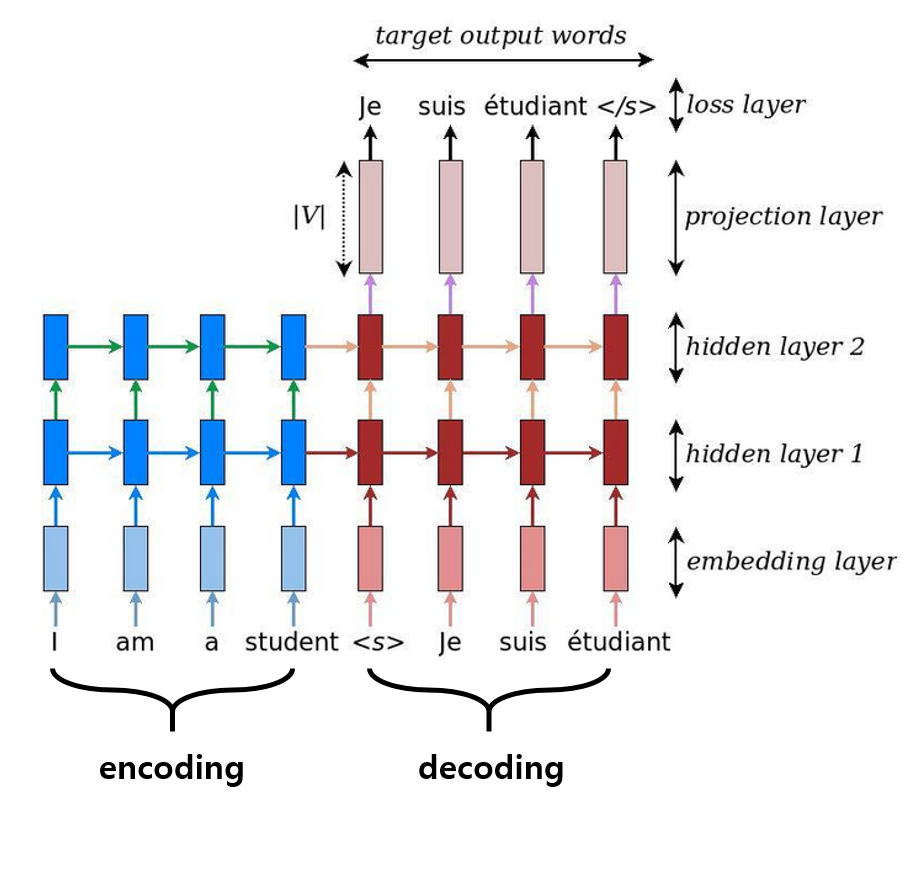
<div style="text-align:center;">Fig 1. Neural Machine Translation / Training Phase</div>
<br/>
The figure above is borrowed from Thang Luong's thesis ['Neural Machine Translation'](https://github.com/lmthang/thesis/blob/master/thesis.pdf)

### Input (1), (3)

`enc_dec_model_inputs` function creates and returns parameters (TF placeholders) related to building model. 
- inputs placeholder will be fed with English sentence data, and its shape is `[None, None]`. The first `None` means the batch size, and the batch size is unknown since user can set it. The second `None` means the lengths of sentences. The maximum length of setence is different from batch to batch, so it cannot be set with the exact number. 
  - One option is to set the lengths of every sentences to the maximum length across all sentences in every batch. No matter which method you choose, you need to add special character, `<PAD>` in empty positions. However, with the latter option, there could be unnecessarily more `<PAD>` characters.
  

- targets placeholder is similar to inputs placeholder except that it will be fed with French sentence data.


- target_sequence_length placeholder represents the lengths of each sentences, so the shape is `None`, a column tensor, which is the same number to the batch size. This particular value is required as an argument of TrainerHelper to build decoder model for training. We will see in (4).


- max_target_len gets the maximum value out of lengths of all the target sentences(sequences). As you know, we have the lengths of all the sentences in target_sequence_length parameter. The way to get the maximum value from it is to use [tf.reduce_max](https://www.tensorflow.org/api_docs/python/tf/reduce_max). 

In [ ]:
def enc_dec_model_inputs():
    inputs = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets') 
    
    target_sequence_length = tf.placeholder(tf.int32, [None], name='target_sequence_length')
    max_target_len = tf.reduce_max(target_sequence_length)    
    
    return inputs, targets, target_sequence_length, max_target_len

`hyperparam_inputs` function creates and returns parameters (TF placeholders) related to hyper-parameters to the model. 
- lr_rate is learning rate
- keep_prob is the keep probability for Dropouts


In [ ]:
def hyperparam_inputs():
    lr_rate = tf.placeholder(tf.float32, name='lr_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    return lr_rate, keep_prob

### Process Decoder Input (3)


On the decoder side, we need two different kinds of input for training and inference purposes repectively. While training phase, the input is provided as target label, but they still need to be embeded. On the inference phase, however, the output of each time step will be the input for the next time step. They also need to be embeded and embedding vector should be shared between two different phases.

preprocess the target label data for the training phase. It is nothing special task. What all you need to do is add `<GO>` special token in front of all target data. `<GO>` token is a kind of guide token as saying like "this is the start of the translation". 
After preprocessing the target label data, we will embed it later when implementing decoding_layer function.

In [ ]:
def process_decoder_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for encoding
    :return: Preprocessed target data
    """
    # get '<GO>' id
    go_id = target_vocab_to_int['<GO>']
    
    after_slice = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    after_concat = tf.concat( [tf.fill([batch_size, 1], go_id), after_slice], 1)
    
    return after_concat

### Encoding (2)

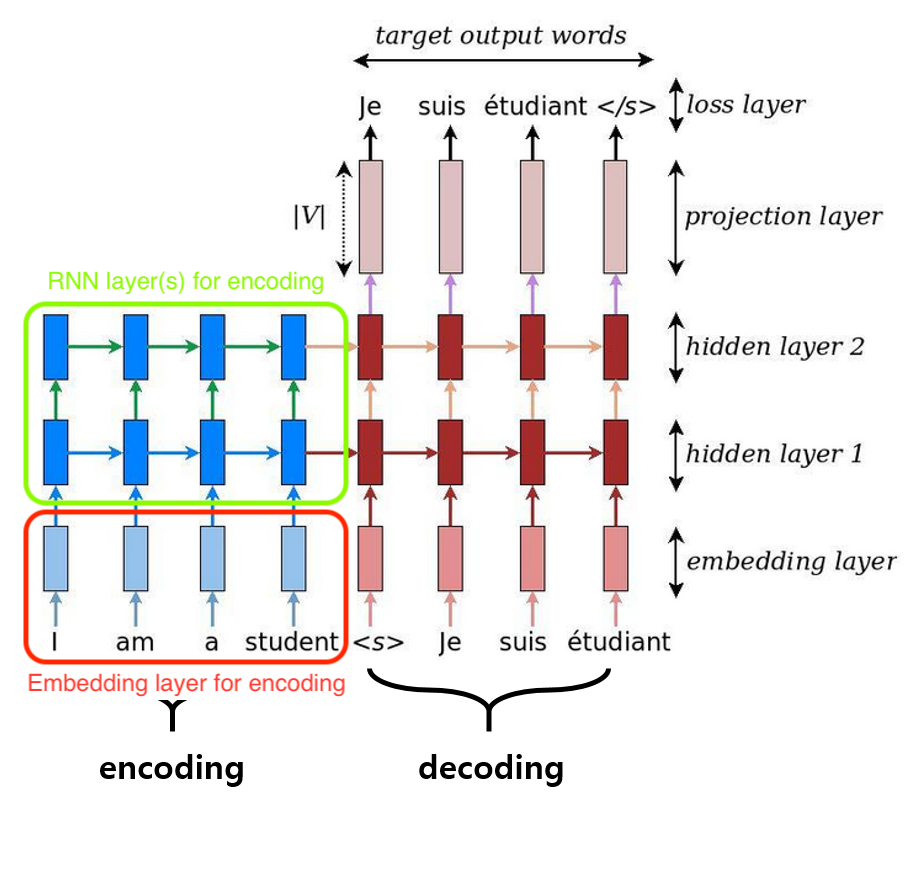
<div style="text-align:center;">Fig 3. Encoding model highlighted - Embedding/RNN layers</div>
<br/>

As depicted in Fig 3, the encoding model consists of two different parts. The first part is the embedding layer. Each word in a sentence will be represented with the number of features specified as `encoding_embedding_size`. This layer gives much richer representative power for the words [useful explanation](https://stackoverflow.com/questions/40784656/tf-contrib-layers-embed-sequence-is-for-what/44280918#44280918). The second part is the RNN layer(s). You can make use of any kind of RNN related techniques or algorithms. For example, in this project, multiple LSTM cells are stacked together after dropout technique is applied. You can use different kinds of RNN cells such as GRU.

Embedding layer
- [TF contrib.layers.embed_sequence](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence)

RNN layers
- [TF contrib.rnn.LSTMCell](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/LSTMCell)
  - simply specifies how many internal units it has
- [TF contrib.rnn.DropoutWrapper](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper)
  - wraps a cell with keep probability value 
- [TF contrib.rnn.MultiRNNCell](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/MultiRNNCell)
  - stacks multiple RNN (type) cells
  - [how this API is used in action?](https://github.com/tensorflow/tensorflow/blob/6947f65a374ebf29e74bb71e36fd82760056d82c/tensorflow/docs_src/tutorials/recurrent.md#stacking-multiple-lstms)
  
Encoding model
- [TF nn.dynamic_rnn](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn)
  - put Embedding layer and RNN layer(s) all together

In [ ]:
def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob, 
                   source_vocab_size, 
                   encoding_embedding_size):
    """
    :return: tuple (RNN output, RNN state)
    """
    embed = tf.contrib.layers.embed_sequence(rnn_inputs, 
                                             vocab_size=source_vocab_size, 
                                             embed_dim=encoding_embedding_size)
    
    stacked_cells = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.LSTMCell(rnn_size), keep_prob) for _ in range(num_layers)])
    
    outputs, state = tf.nn.dynamic_rnn(stacked_cells, 
                                       embed, 
                                       dtype=tf.float32)
    return outputs, state

### Decoding - Training process (4)

Decoding model can be thought of two separate processes, training and inference. It is not they have different architecture, but they share the same architecture and its parameters. It is that they have different strategy to feed the shared model.

For this(training) and the next(inference) section, Fig 4 shows clearly shows what they are.

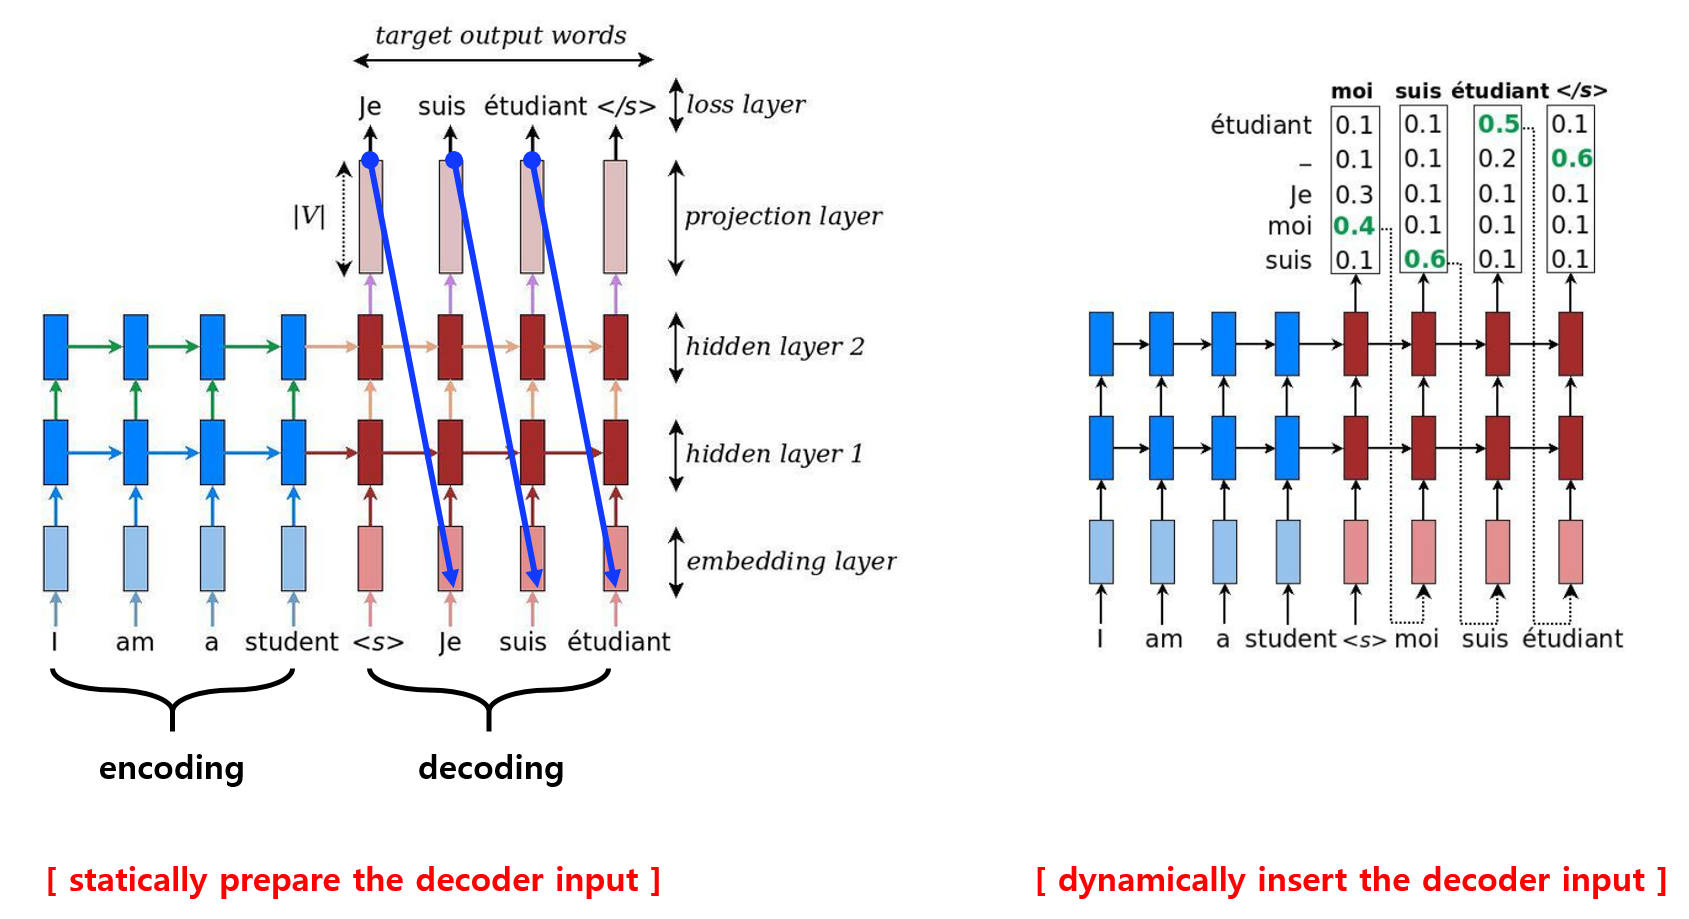
<div style="text-align:center;">Fig 4. Decoder shifted inputs</div>
<br/>

While encoder uses [TF contrib.layers.embed_sequence](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence), it is not applicable to decoder even though it may require its input embeded. That is because the same embedding vector should be shared via training and inferece phases. [TF contrib.layers.embed_sequence](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence) can only embed the prepared dataset before running. What needed for inference process is dynamic embedding capability. It is impossible to embed the output from the inference process before running the model because the output of the current time step will be the input of the next time step.

For the training part, embeded input should be delivered. On the inference part, only embedding parameters used in the training part should be delivered.

Let's see the training part first. 
- [`tf.contrib.seq2seq.TrainingHelper`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/TrainingHelper)
  - TrainingHelper is where we pass the embeded input. As the name indicates, this is only a helper instance. This instance should be delivered to the BasicDecoder, which is the actual process of building the decoder model.
- [`tf.contrib.seq2seq.BasicDecoder`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BasicDecoder)
  - BasicDecoder builds the decoder model. It means it connects the RNN layer(s) on the decoder side and the input prepared by TrainingHelper.
- [`tf.contrib.seq2seq.dynamic_decode`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_decode)
  - dynamic_decode unrolls the decoder model so that actual prediction can be retrieved by BasicDecoder for each time steps.

In [ ]:
def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, 
                         target_sequence_length, max_summary_length, 
                         output_layer, keep_prob):
    """
    Create a training process in decoding layer 
    :return: BasicDecoderOutput containing training logits and sample_id
    """
    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, 
                                             output_keep_prob=keep_prob)
    
    # for only input layer
    helper = tf.contrib.seq2seq.TrainingHelper(dec_embed_input, 
                                               target_sequence_length)
    
    decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, 
                                              helper, 
                                              encoder_state, 
                                              output_layer)

    # unrolling the decoder layer
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, 
                                                      impute_finished=True, 
                                                      maximum_iterations=max_summary_length)
    return outputs

### Decoding - Inference process (5)

- [`tf.contrib.seq2seq.GreedyEmbeddingHelper`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/GreedyEmbeddingHelper)
  - GreedyEmbeddingHelper dynamically takes the output of the current step and give it to the next time step's input. In order to embed the each input result dynamically, embedding parameter(just bunch of weight values) should be provided. Along with it, GreedyEmbeddingHelper asks to give the `start_of_sequence_id` for the same amount as the batch size and `end_of_sequence_id`.
- [`tf.contrib.seq2seq.BasicDecoder`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BasicDecoder)
  - same as described in the training process section
- [`tf.contrib.seq2seq.dynamic_decode`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_decode)
  - same as described in the training process section

In [ ]:
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id,
                         end_of_sequence_id, max_target_sequence_length,
                         vocab_size, output_layer, batch_size, keep_prob):
    """
    Create a inference process in decoding layer 
    :return: BasicDecoderOutput containing inference logits and sample_id
    """
    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, 
                                             output_keep_prob=keep_prob)
    
    helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(dec_embeddings, 
                                                      tf.fill([batch_size], start_of_sequence_id), 
                                                      end_of_sequence_id)
    
    decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, 
                                              helper, 
                                              encoder_state, 
                                              output_layer)
    
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, 
                                                      impute_finished=True, 
                                                      maximum_iterations=max_target_sequence_length)
    return outputs

### Build the Decoding Layer (3), (6)

__Embed the target sequences__

- [TF contrib.layers.embed_sequence](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence) creates internal representation of embedding parameter, so we cannot look into or retrieve it. Rather, you need to create a embedding parameter manually by [TF Variable](https://www.tensorflow.org/api_docs/python/tf/Variable). 

- Manually created embedding parameter is used for training phase to convert provided target data(sequence of sentence) by [TF nn.embedding_lookup](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) before the training is run. [TF nn.embedding_lookup](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) with manually created embedding parameters returns the similar result to the [TF contrib.layers.embed_sequence](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence). For the inference process, whenever the output of the current time step is calculated via decoder, it will be embeded by the shared embedding parameter and become the input for the next time step. You only need to provide the embedding parameter to the GreedyEmbeddingHelper, then it will help the process.

- [How embedding_lookup works?](https://stackoverflow.com/questions/34870614/what-does-tf-nn-embedding-lookup-function-do)
  - In short, it selects specified rows
  


__Construct the decoder RNN layer(s)__
- As depicted in Fig 3 and Fig 4, the number of RNN layer in the decoder model has to be equal to the number of RNN layer(s) in the encoder model.

__Create an output layer to map the outputs of the decoder to the elements of our vocabulary__
- This is just a fully connected layer to get probabilities of occurance of each words at the end.

In [ ]:
def decoding_layer(dec_input, encoder_state,
                   target_sequence_length, max_target_sequence_length,
                   rnn_size,
                   num_layers, target_vocab_to_int, target_vocab_size,
                   batch_size, keep_prob, decoding_embedding_size):
    """
    Create decoding layer
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    target_vocab_size = len(target_vocab_to_int)
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, dec_input)
    
    cells = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(rnn_size) for _ in range(num_layers)])
    
    with tf.variable_scope("decode"):
        output_layer = tf.layers.Dense(target_vocab_size)
        train_output = decoding_layer_train(encoder_state, 
                                            cells, 
                                            dec_embed_input, 
                                            target_sequence_length, 
                                            max_target_sequence_length, 
                                            output_layer, 
                                            keep_prob)

    with tf.variable_scope("decode", reuse=True):
        infer_output = decoding_layer_infer(encoder_state, 
                                            cells, 
                                            dec_embeddings, 
                                            target_vocab_to_int['<GO>'], 
                                            target_vocab_to_int['<EOS>'], 
                                            max_target_sequence_length, 
                                            target_vocab_size, 
                                            output_layer,
                                            batch_size,
                                            keep_prob)

    return (train_output, infer_output)

### Build the Seq2Seq model (7)

In this section, previously defined functions, `encoding_layer`, `process_decoder_input`, and `decoding_layer` are put together to build the big picture, Sequence to Sequence model. 

In [ ]:
def seq2seq_model(input_data, target_data, keep_prob, batch_size,
                  target_sequence_length,
                  max_target_sentence_length,
                  source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size,
                  rnn_size, num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence model
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    enc_outputs, enc_states = encoding_layer(input_data, 
                                             rnn_size, 
                                             num_layers, 
                                             keep_prob, 
                                             source_vocab_size, 
                                             enc_embedding_size)
    
    dec_input = process_decoder_input(target_data, 
                                      target_vocab_to_int, 
                                      batch_size)
    
    train_output, infer_output = decoding_layer(dec_input,
                                               enc_states, 
                                               target_sequence_length, 
                                               max_target_sentence_length,
                                               rnn_size,
                                              num_layers,
                                              target_vocab_to_int,
                                              target_vocab_size,
                                              batch_size,
                                              keep_prob,
                                              dec_embedding_size)
    
    return train_output, infer_output

## Neural Network Training
### Hyperparameters

In [ ]:
display_step = 300

epochs = 13
batch_size = 128

rnn_size = 128
num_layers = 3

encoding_embedding_size = 200
decoding_embedding_size = 200

learning_rate = 0.001
keep_probability = 0.5

### Build the Graph
`seq2seq_model` function creates the model. It defines how the feedforward and backpropagation should flow. The last step for this model to be trainable is deciding and applying what optimization algorithms to use. In this section, [TF contrib.seq2seq.sequence_loss](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/sequence_loss) is used to calculate the loss, then [TF train.AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) is applied to calculate the gradient descent on the loss. Let's go over eatch steps in the code cell below.

__load data from the checkpoint__
- (source_int_text, target_int_text) are the input data, and (source_vocab_to_int, target_vocab_to_int) is the dictionary to lookup the index number of each words.
- max_target_sentence_length is the length of the longest sentence from the source input data. This will be used for GreedyEmbeddingHelper when building inference process in the decoder mode.

__create inputs__
- inputs (input_data, targets, target_sequence_length, max_target_sequence_length) from enc_dec_model_inputs function
- inputs (lr, keep_prob) from hyperparam_inputs function

__build seq2seq model__
- build the model by seq2seq_model function. It will return train_logits(logits to calculate the loss) and inference_logits(logits from prediction).

__cost function__
- [TF contrib.seq2seq.sequence_loss](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/sequence_loss) is used. This loss function is just a weighted softmax cross entropy loss function, but it is particularly designed to be applied in time series model (RNN). Weights should be explicitly provided as an argument, and it can be created by [TF sequence_mask](https://www.tensorflow.org/api_docs/python/tf/sequence_mask). In this project, [TF sequence_mask](https://www.tensorflow.org/api_docs/python/tf/sequence_mask) creates \[batch_size, max_target_sequence_length\] size of variable, then maks only the first target_sequence_length number of elements to 1. It means <PAD\> parts will have less weight than others.

__Optimizer__
- [TF train.AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) is used, and this is where the learning rate should be specified. You can choose other algorithms as well, this is just a choice.

__Gradient Clipping__
- Since recurrent neural networks is notorious about vanishing/exploding gradient, gradient clipping technique is believed to improve the issues. 
- The concept is really easy. You decide thresholds to keep the gradient to be in a certain boundary. In this project, the range of the threshold is between -1 and 1.
- Now, you need to apply this conceptual knowledge to the TensorFlow code. Luckily, there is the official guide for this [TF Gradient Clipping How?](https://www.tensorflow.org/api_guides/python/train#Gradient_Clipping). In breif, you get the gradient values from the optimizer manually by calling [compute_gradients](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer#compute_gradients), then manipulate the gradient values with [clip_by_value](https://www.tensorflow.org/api_docs/python/tf/clip_by_value). Lastly, you need to put back the modified gradients into the optimizer by calling [apply_gradients](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer#apply_gradients)

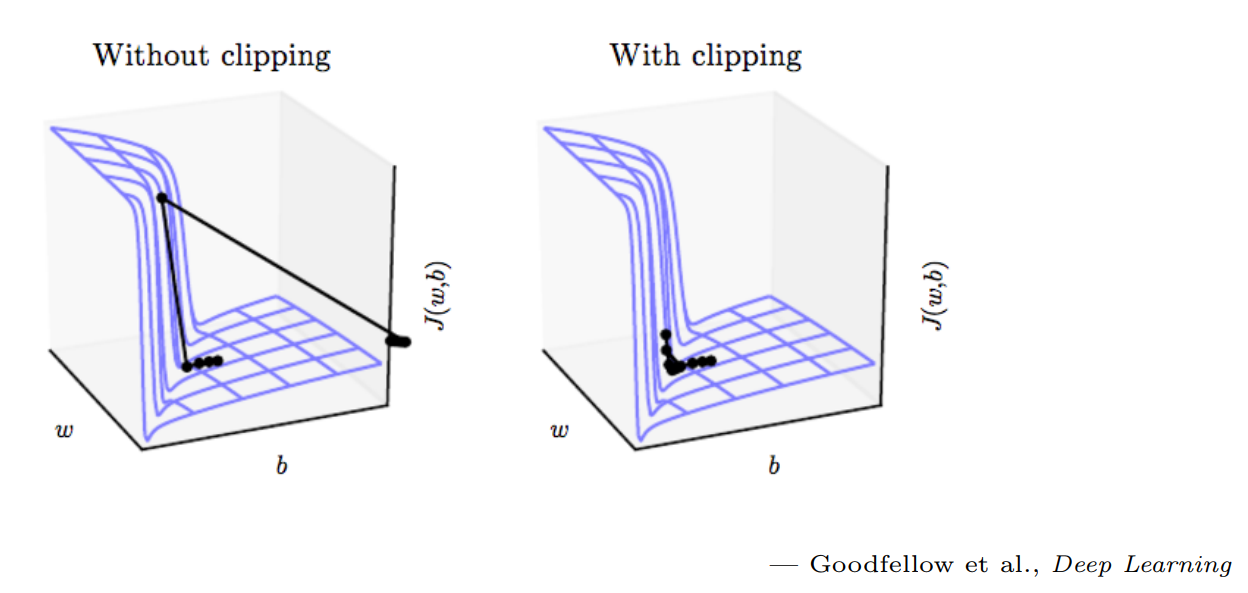
<div style="text-align:center;">Fig 4. Gradient Clipping</div>
<br/>

In [ ]:
save_path = 'checkpoints/dev'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = load_preprocess()
max_target_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, target_sequence_length, max_target_sequence_length = enc_dec_model_inputs()
    lr, keep_prob = hyperparam_inputs()
    
    train_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                   targets,
                                                   keep_prob,
                                                   batch_size,
                                                   target_sequence_length,
                                                   max_target_sequence_length,
                                                   len(source_vocab_to_int),
                                                   len(target_vocab_to_int),
                                                   encoding_embedding_size,
                                                   decoding_embedding_size,
                                                   rnn_size,
                                                   num_layers,
                                                   target_vocab_to_int)
    
    training_logits = tf.identity(train_logits.rnn_output, name='logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')

    # https://www.tensorflow.org/api_docs/python/tf/sequence_mask
    # - Returns a mask tensor representing the first N positions of each cell.
    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function - weighted softmax cross entropy
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as

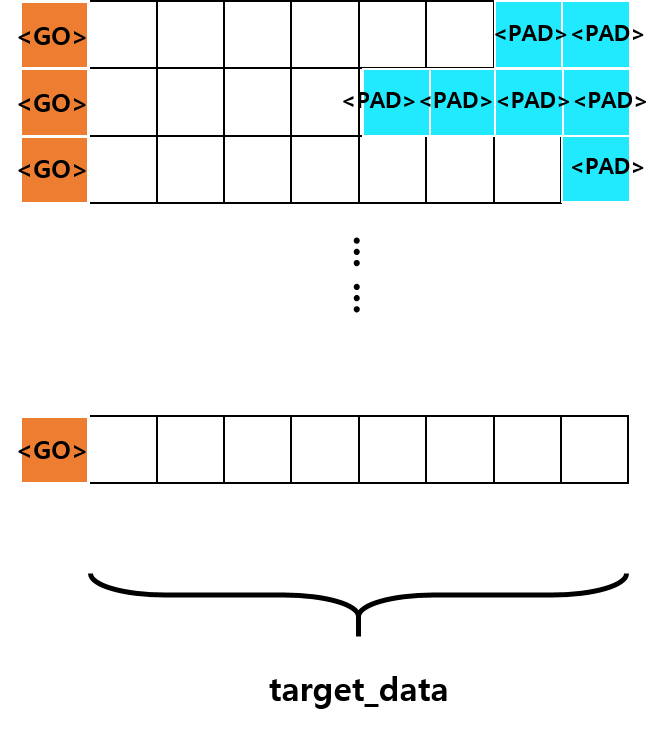

### Get Batches and Pad the source and target sequences
<br/>



In [ ]:
def pad_sentence_batch(sentence_batch, pad_int):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_int] * (max_sentence - len(sentence)) for sentence in sentence_batch]


def get_batches(sources, targets, batch_size, source_pad_int, target_pad_int):
    """Batch targets, sources, and the lengths of their sentences together"""
    for batch_i in range(0, len(sources)//batch_size):
        start_i = batch_i * batch_size

        # Slice the right amount for the batch
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]

        # Pad
        pad_sources_batch = np.array(pad_sentence_batch(sources_batch, source_pad_int))
        pad_targets_batch = np.array(pad_sentence_batch(targets_batch, target_pad_int))

        # Need the lengths for the _lengths parameters
        pad_targets_lengths = []
        for target in pad_targets_batch:
            pad_targets_lengths.append(len(target))

        pad_source_lengths = []
        for source in pad_sources_batch:
            pad_source_lengths.append(len(source))

        yield pad_sources_batch, pad_targets_batch, pad_source_lengths, pad_targets_lengths

### Train

`get_accuracy`
- compare the lengths of target(label) and logits(prediction)
- add(pad) 0s at the end of the ones having the shorter length
  - `[(0,0),(0,max_seq - target.shape[1])]` indicates the 2D array. The first (0,0) means no padding for the first dimension. The second (0, ...) means there is no pads in front of the second dimension but pads at the end. And pad as many times as ... .
- above process is to makes two entities to have the same shape (length)
- finally, returns the average of where the target and logits have the same value (1)



In [ ]:
def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1])],
            'constant')

    return np.mean(np.equal(target, logits))

# Split data to training and validation sets
train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]
valid_source = source_int_text[:batch_size]
valid_target = target_int_text[:batch_size]
(valid_sources_batch, valid_targets_batch, valid_sources_lengths, valid_targets_lengths ) = next(get_batches(valid_source,
                                                                                                             valid_target,
                                                                                                             batch_size,
                                                                                                             source_vocab_to_int['<PAD>'],
                                                                                                             target_vocab_to_int['<PAD>']))                                                                                                  
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch, sources_lengths, targets_lengths) in enumerate(
                get_batches(train_source, train_target, batch_size,
                            source_vocab_to_int['<PAD>'],
                            target_vocab_to_int['<PAD>'])):

            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 target_sequence_length: targets_lengths,
                 keep_prob: keep_probability})


            if batch_i % display_step == 0 and batch_i > 0:
                batch_train_logits = sess.run(
                    inference_logits,
                    {input_data: source_batch,
                     target_sequence_length: targets_lengths,
                     keep_prob: 1.0})

                batch_valid_logits = sess.run(
                    inference_logits,
                    {input_data: valid_sources_batch,
                     target_sequence_length: valid_targets_lengths,
                     keep_prob: 1.0})

                train_acc = get_accuracy(target_batch, batch_train_logits)
                valid_acc = get_accuracy(valid_targets_batch, batch_valid_logits)

                print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.4f}, Validation Accuracy: {:>6.4f}, Loss: {:>6.4f}'
                      .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved')

Epoch   0 Batch  300/1077 - Train Accuracy: 0.4342, Validation Accuracy: 0.5142, Loss: 2.0535
Epoch   0 Batch  600/1077 - Train Accuracy: 0.5104, Validation Accuracy: 0.5323, Loss: 1.1553
Epoch   0 Batch  900/1077 - Train Accuracy: 0.5492, Validation Accuracy: 0.5550, Loss: 0.9252
Epoch   1 Batch  300/1077 - Train Accuracy: 0.5958, Validation Accuracy: 0.6236, Loss: 0.7104
Epoch   1 Batch  600/1077 - Train Accuracy: 0.6198, Validation Accuracy: 0.6126, Loss: 0.5666
Epoch   1 Batch  900/1077 - Train Accuracy: 0.6520, Validation Accuracy: 0.6445, Loss: 0.5431
Epoch   2 Batch  300/1077 - Train Accuracy: 0.7109, Validation Accuracy: 0.7045, Loss: 0.4336
Epoch   2 Batch  600/1077 - Train Accuracy: 0.7716, Validation Accuracy: 0.7688, Loss: 0.3775
Epoch   2 Batch  900/1077 - Train Accuracy: 0.8000, Validation Accuracy: 0.7944, Loss: 0.3340
Epoch   3 Batch  300/1077 - Train Accuracy: 0.8651, Validation Accuracy: 0.8320, Loss: 0.2473
Epoch   3 Batch  600/1077 - Train Accuracy: 0.8512, Validati

### Save Parameters
Save the `batch_size` and `save_path` parameters for inference.

In [ ]:
def save_params(params):
    with open('params.p', 'wb') as out_file:
        pickle.dump(params, out_file)


def load_params():
    with open('params.p', mode='rb') as in_file:
        return pickle.load(in_file)

In [ ]:
# Save parameters for checkpoint
save_params(save_path)

# Checkpoint

In [ ]:
import tensorflow as tf
import numpy as np
#import problem_unittests as tests

_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = load_preprocess()
load_path = load_params()

## Translate
This will translate `translate_sentence` from English to French.

In [ ]:
def sentence_to_seq(sentence, vocab_to_int):
    results = []
    for word in sentence.split(" "):
        if word in vocab_to_int:
            results.append(vocab_to_int[word])
        else:
            results.append(vocab_to_int['<UNK>'])
            
    return results

translate_sentence = 'he saw a old yellow truck .'

translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence]*batch_size,
                                         target_sequence_length: [len(translate_sentence)*2]*batch_size,
                                         keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence]))
print('  English Words: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in translate_logits]))
print('  French Words: {}'.format(" ".join([target_int_to_vocab[i] for i in translate_logits])))

INFO:tensorflow:Restoring parameters from checkpoints/dev
Input
  Word Ids:      [197, 182, 178, 155, 172, 103, 127]
  English Words: ['he', 'saw', 'a', 'old', 'yellow', 'truck', '.']

Prediction
  Word Ids:      [50, 251, 185, 5, 176, 231, 118, 223, 1]
  French Words: il a vu un vieux camion noir . <EOS>
